In [2]:
pip install -q torch torchvision onnxruntime-gpu tqdm onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.3 MB/s eta 0:00:00


Device: cuda


СРАВНЕНИЕ ПРЕДОБУЧЕННЫХ EFFICIENTNET-B0 и B3

Начинаем обучение EfficientNet-B0...


ДООБУЧЕНИЕ EfficientNet-B0
Создана модель EfficientNet-B0
Параметры: 4.0M
Обучаемые параметры: 3.2M

Начинаем обучение (ранняя остановка с patience=3, target=87.0%)...


Epoch 1/10: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s, loss=0.843, acc=0.858]


Epoch 1: Val Acc = 92.47% | LR = 9.76e-04
Целевая точность 87.0% достигнута!
  💾 Сохранен checkpoint (Acc: 92.47%)

Ранняя остановка на эпохе 1
   Лучшая точность: 92.47% на эпохе 1
Достигнута целевая accuracy

Обучение завершено
Лучшая точность на валидации: 92.47% (эпоха 1)

Начинаем обучение EfficientNet-B3...


ДООБУЧЕНИЕ EfficientNet-B3
Создана модель EfficientNet-B3
Параметры: 10.7M
Обучаемые параметры: 8.5M

Начинаем обучение (ранняя остановка с patience=3, target=87.0%)...


Epoch 1/10: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s, loss=0.794, acc=0.88]


Epoch 1: Val Acc = 93.86% | LR = 9.76e-04
Целевая точность 87.0% достигнута!
  💾 Сохранен checkpoint (Acc: 93.86%)

Ранняя остановка на эпохе 1
   Лучшая точность: 93.86% на эпохе 1
Достигнута целевая accuracy

Обучение завершено
Лучшая точность на валидации: 93.86% (эпоха 1)


ПОДГОТОВКА ДАННЫХ ДЛЯ ТЕСТИРОВАНИЯ


ИЗМЕРЕНИЕ ФИНАЛЬНОЙ ТОЧНОСТИ

Измеряем финальную accuracy...
EfficientNet-B0: 92.47%
EfficientNet-B3: 93.86%

📈 Разница в точности (B3 - B0): +1.39%

ИЗМЕРЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ

Измеряем FPS...
✅ EfficientNet-B0: 548.1 FPS
✅ EfficientNet-B3: 386.6 FPS

Прирост FPS (B0 / B3): 1.42x
   (B0 быстрее B3 в 1.4 раз)

СРАВНЕНИЕ ПАРАМЕТРОВ
EfficientNet-B0: 4,020,358 параметров (4.0M)
EfficientNet-B3: 10,711,602 параметров (10.7M)
B3 имеет в 2.7 раз больше параметров


ИНФОРМАЦИЯ О СОХРАНЕННЫХ ЧЕКПОЙНТАХ

Checkpoint B0: efficientnet_b0_checkpoint.tar
   Эпоха: 1
   Точность: 92.47%
   Цель достигнута: Да
   Эпох обучено: 1

 Checkpoint B3: efficientnet_b3_checkpoint.tar
   Эпоха: 1
 

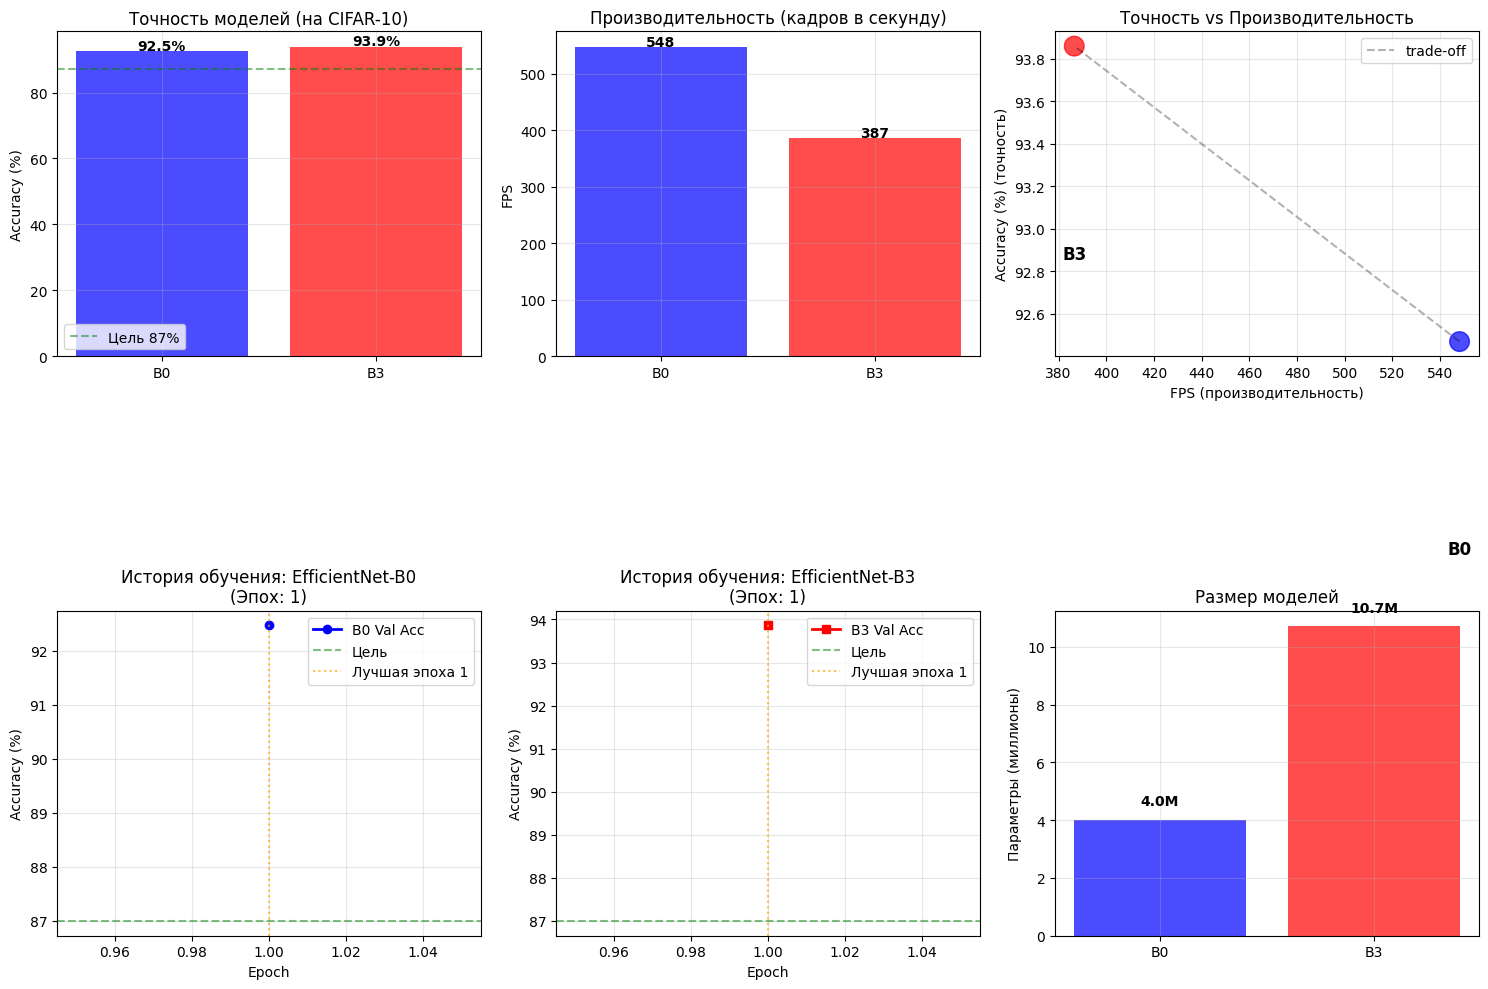


ИЗМЕРЕНИЕ LATENCY ОДНОЙ КАРТИНКИ (100 ПРОГОНОВ)

Измеряем latency для B0...

Измеряем latency для B3...

📊 LATENCY РЕЗУЛЬТАТЫ (мс):
Метрика    | B0         | B3         | Отношение (B3/B0)
--------------------------------------------------
Mean       |  8.777 ms | 18.110 ms |    2.06x
Std        |  1.165 ms |  2.911 ms |    2.50x
Min        |  7.851 ms | 14.978 ms |    1.91x
Max        | 15.157 ms | 27.131 ms |    1.79x
p50        |  8.358 ms | 16.921 ms |    2.02x
p95        | 10.887 ms | 23.517 ms |    2.16x
p99        | 14.107 ms | 26.714 ms |    1.89x

ВИЗУАЛИЗАЦИЯ LATENCY


/tmp/ipython-input-1079718235.py:655: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[1, 1].boxplot(box_data, patch_artist=True,


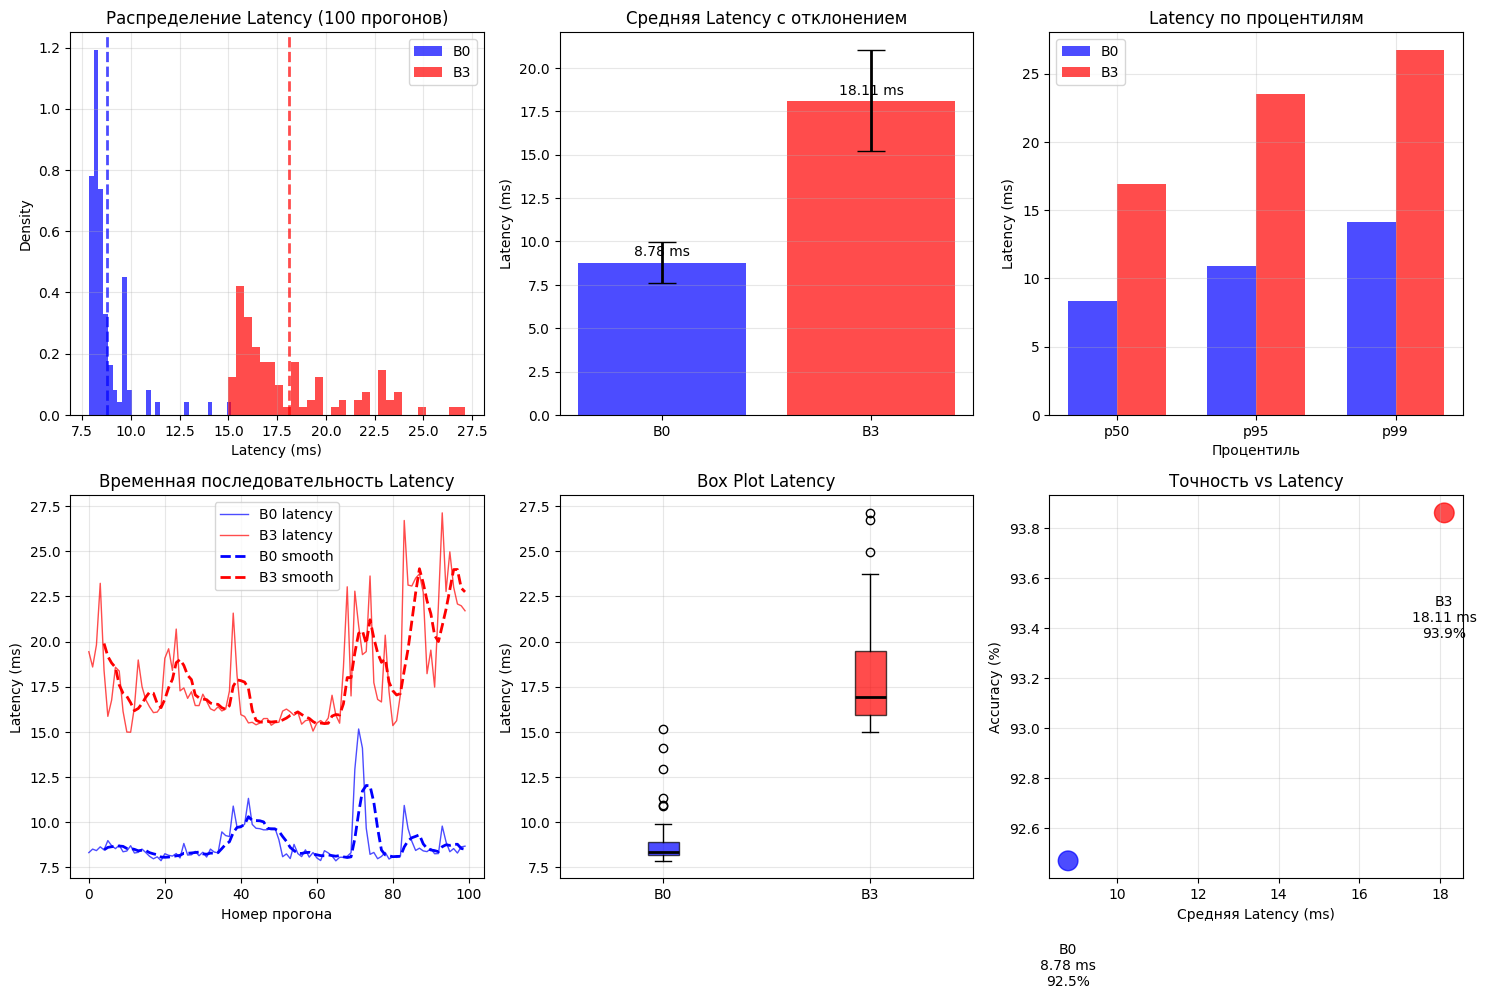


✅ График latency сохранен: docs/latency.png


In [15]:
if __name__ == "__main__":
    import torch
    import torchvision
    import torch.nn as nn
    import torch.optim as optim
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader
    import time
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    from tqdm import tqdm

    # ======= НАСТРОЙКИ =======
    SEED = 42
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    # ======= ФУНКЦИЯ ДЛЯ ОБУЧЕНИЯ МОДЕЛИ С РАННЕЙ ОСТАНОВКОЙ =======
    def train_efficientnet(model_name='b0', num_epochs=10, patience=5, target_acc=0.87):
        """Дообучает предобученную EfficientNet на CIFAR-10 с ранней остановкой"""
        print(f"\n")
        print(f"ДООБУЧЕНИЕ EfficientNet-{model_name.upper()}")

        # ======= 1. СОЗДАНИЕ МОДЕЛИ =======
        if model_name == 'b0':
            model = torchvision.models.efficientnet_b0(
                weights=torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
            )
        else:  # 'b3'
            model = torchvision.models.efficientnet_b3(
                weights=torchvision.models.EfficientNet_B3_Weights.IMAGENET1K_V1
            )

        # Замораживаем все слои кроме последних
        for param in model.parameters():
            param.requires_grad = False

        # Размораживаем последние слои и classifier
        for param in model.features[-3:].parameters():
            param.requires_grad = True
        for param in model.classifier.parameters():
            param.requires_grad = True

        # Заменяем последний слой для 10 классов CIFAR-10
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, 10)

        model = model.to(device)
        print(f"Создана модель EfficientNet-{model_name.upper()}")
        print(f"Параметры: {sum(p.numel() for p in model.parameters())/1e6:.1f}M")
        print(f"Обучаемые параметры: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.1f}M")

        # ======= 2. ДАННЫЕ =======
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        val_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        train_ds = datasets.CIFAR10(root="data", train=True, download=True, transform=train_transform)
        val_ds = datasets.CIFAR10(root="data", train=False, download=True, transform=val_transform)

        train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

        # ======= 3. ОБУЧЕНИЕ С РАННЕЙ ОСТАНОВКОЙ =======
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        best_val_acc = 0.0
        best_epoch = 0
        patience_counter = 0
        history = {'train_loss': [], 'val_acc': [], 'epochs_completed': 0}

        print(f"\nНачинаем обучение (ранняя остановка с patience={patience}, target={target_acc*100:.1f}%)...")

        for epoch in range(num_epochs):
            # Training
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
            for x, y in pbar:
                x, y = x.to(device), y.to(device)

                optimizer.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * x.size(0)
                _, predicted = outputs.max(1)
                train_correct += predicted.eq(y).sum().item()
                train_total += y.size(0)

                pbar.set_postfix({
                    'loss': train_loss/train_total,
                    'acc': train_correct/train_total
                })

            # Validation
            model.eval()
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    outputs = model(x)
                    _, predicted = outputs.max(1)
                    val_correct += predicted.eq(y).sum().item()
                    val_total += y.size(0)

            val_acc = val_correct / val_total
            scheduler.step()

            history['train_loss'].append(train_loss/train_total)
            history['val_acc'].append(val_acc)
            history['epochs_completed'] = epoch + 1

            print(f"Epoch {epoch+1}: Val Acc = {val_acc*100:.2f}% | LR = {scheduler.get_last_lr()[0]:.2e}")

            # Проверяем достижение цели
            if val_acc >= target_acc:
                print(f"Целевая точность {target_acc*100:.1f}% достигнута!")
                target_reached = True
            else:
                target_reached = False

            # Сохраняем лучшую модель как checkpoint.tar
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch + 1
                patience_counter = 0  # Сбрасываем счетчик patience

                # Сохраняем полный checkpoint
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'val_acc': val_acc,
                    'train_loss': train_loss/train_total,
                    'history': history,
                    'model_name': model_name,
                    'best_epoch': best_epoch,
                    'target_reached': target_reached,
                    'target_acc': target_acc,
                }

                torch.save(checkpoint, f'efficientnet_{model_name}_checkpoint.tar')
                print(f"  💾 Сохранен checkpoint (Acc: {val_acc*100:.2f}%)")

                # Также сохраняем лучшие веса отдельно для совместимости
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'val_acc': val_acc,
                }, f'efficientnet_{model_name}_best.pth')
            else:
                patience_counter += 1
                print(f"  ⏳ Patience: {patience_counter}/{patience}")

            # Ранняя остановка по patience
            if patience_counter >= patience:
                print(f"\nРанняя остановка на эпохе {epoch+1}")
                print(f"   Лучшая точность: {best_val_acc*100:.2f}% на эпохе {best_epoch}")
                print(f"   Пациенс исчерпан ({patience_counter}/{patience})")
                break
            elif target_reached:
                print(f"\nРанняя остановка на эпохе {epoch+1}")
                print(f"   Лучшая точность: {best_val_acc*100:.2f}% на эпохе {best_epoch}")
                print(f"Достигнута целевая accuracy")
                break

        print(f"\nОбучение завершено")
        print(f"Лучшая точность на валидации: {best_val_acc*100:.2f}% (эпоха {best_epoch})")

        # Загружаем лучшие веса из checkpoint
        checkpoint = torch.load(f'efficientnet_{model_name}_checkpoint.tar', map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])

        return model, best_val_acc, history, checkpoint

    # ======= ФУНКЦИИ ДЛЯ ИЗМЕРЕНИЙ =======
    def measure_accuracy(model, loader):
        """Измеряет accuracy модели"""
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                _, predicted = outputs.max(1)
                correct += predicted.eq(y).sum().item()
                total += y.size(0)
        return correct / total

    def measure_fps(model, loader, warmup=10, test_batches=50):
        """Измеряет FPS (кадров в секунду)"""
        model.eval()

        # Warm-up
        with torch.no_grad():
            for i, (x, _) in enumerate(loader):
                if i >= warmup:
                    break
                x = x.to(device)
                _ = model(x)

        # Измерение
        if device.type == "cuda":
            torch.cuda.synchronize()

        start_time = time.time()
        total_images = 0

        with torch.no_grad():
            for i, (x, _) in enumerate(loader):
                if i >= test_batches:
                    break
                x = x.to(device)
                _ = model(x)
                total_images += x.size(0)

        if device.type == "cuda":
            torch.cuda.synchronize()

        elapsed = time.time() - start_time
        fps = total_images / elapsed
        return fps

    # ======= ГЛАВНЫЙ БЛОК =======
    print("\n")
    print("СРАВНЕНИЕ ПРЕДОБУЧЕННЫХ EFFICIENTNET-B0 и B3")

    # ======= 1. ОБУЧАЕМ ОБЕ МОДЕЛИ С РАННЕЙ ОСТАНОВКОЙ =======
    # Обучаем B0
    print("\nНачинаем обучение EfficientNet-B0...")
    model_b0, b0_best_acc, history_b0, checkpoint_b0 = train_efficientnet(
        'b0',
        num_epochs=10,  # Кол-во эпох
        patience=3,     # Останавливаемся если 3 эпохи без улучшений
        target_acc=0.87 # Целевая точность
    )

    # Обучаем B3
    print("\nНачинаем обучение EfficientNet-B3...")
    model_b3, b3_best_acc, history_b3, checkpoint_b3 = train_efficientnet(
        'b3',
        num_epochs=10,
        patience=3,
        target_acc=0.87
    )

    # ======= 2. ПОДГОТОВКА ДАННЫХ ДЛЯ ТЕСТИРОВАНИЯ =======
    print("\n")
    print("ПОДГОТОВКА ДАННЫХ ДЛЯ ТЕСТИРОВАНИЯ")

    test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    test_ds = datasets.CIFAR10(root="data", train=False, download=True, transform=test_transform)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

    # ======= 3. ИЗМЕРЕНИЕ ТОЧНОСТИ =======
    print("\n")
    print("ИЗМЕРЕНИЕ ФИНАЛЬНОЙ ТОЧНОСТИ")

    print("\nИзмеряем финальную accuracy...")
    b0_final_acc = measure_accuracy(model_b0, test_loader)
    b3_final_acc = measure_accuracy(model_b3, test_loader)

    print(f"EfficientNet-B0: {b0_final_acc*100:.2f}%")
    print(f"EfficientNet-B3: {b3_final_acc*100:.2f}%")

    accuracy_drop = b3_final_acc - b0_final_acc  # B3 должен быть лучше
    print(f"\n📈 Разница в точности (B3 - B0): {accuracy_drop*100:+.2f}%")

    # ======= 4. ИЗМЕРЕНИЕ FPS =======
    print("\n" + "="*60)
    print("ИЗМЕРЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ")
    print("="*60)

    print("\nИзмеряем FPS...")
    b0_fps = measure_fps(model_b0, test_loader, test_batches=100)
    b3_fps = measure_fps(model_b3, test_loader, test_batches=100)

    print(f"✅ EfficientNet-B0: {b0_fps:.1f} FPS")
    print(f"✅ EfficientNet-B3: {b3_fps:.1f} FPS")

    fps_gain = b0_fps / b3_fps  # B0 должен быть быстрее
    print(f"\nПрирост FPS (B0 / B3): {fps_gain:.2f}x")
    print(f"   (B0 быстрее B3 в {fps_gain:.1f} раз)")

    # ======= 5. ПАРАМЕТРЫ МОДЕЛЕЙ =======
    print("\n" + "="*60)
    print("СРАВНЕНИЕ ПАРАМЕТРОВ")
    print("="*60)

    b0_params = sum(p.numel() for p in model_b0.parameters())
    b3_params = sum(p.numel() for p in model_b3.parameters())

    print(f"EfficientNet-B0: {b0_params:,} параметров ({b0_params/1e6:.1f}M)")
    print(f"EfficientNet-B3: {b3_params:,} параметров ({b3_params/1e6:.1f}M)")
    print(f"B3 имеет в {b3_params/b0_params:.1f} раз больше параметров")

    # ======= 6. ИНФОРМАЦИЯ О ЧЕКПОЙНТАХ =======
    print("\n")
    print("ИНФОРМАЦИЯ О СОХРАНЕННЫХ ЧЕКПОЙНТАХ")

    print(f"\nCheckpoint B0: efficientnet_b0_checkpoint.tar")
    print(f"   Эпоха: {checkpoint_b0['epoch'] + 1}")
    print(f"   Точность: {checkpoint_b0['val_acc']*100:.2f}%")
    print(f"   Цель достигнута: {'Да' if checkpoint_b0.get('target_reached', False) else 'Нет'}")
    print(f"   Эпох обучено: {checkpoint_b0['history']['epochs_completed']}")

    print(f"\n Checkpoint B3: efficientnet_b3_checkpoint.tar")
    print(f"   Эпоха: {checkpoint_b3['epoch'] + 1}")
    print(f"   Точность: {checkpoint_b3['val_acc']*100:.2f}%")
    print(f"   Цель достигнута: {'Да' if checkpoint_b3.get('target_reached', False) else 'Нет'}")
    print(f"   Эпох обучено: {checkpoint_b3['history']['epochs_completed']}")

    # ======= 7. ФУНКЦИЯ ДЛЯ ЗАГРУЗКИ ЧЕКПОЙНТА =======
    def load_checkpoint(model_name, device):
        """Загружает модель из checkpoint.tar"""
        checkpoint_path = f'efficientnet_{model_name}_checkpoint.tar'

        if not os.path.exists(checkpoint_path):
            print(f"Файл {checkpoint_path} не найден!")
            return None

        # Загружаем checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Создаем модель
        if model_name == 'b0':
            model = torchvision.models.efficientnet_b0(weights=None)
        else:
            model = torchvision.models.efficientnet_b3(weights=None)

        # Настраиваем classifier
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, 10)
        model = model.to(device)

        # Загружаем веса
        model.load_state_dict(checkpoint['model_state_dict'])

        print(f"\nЗагружен checkpoint {checkpoint_path}")
        print(f"   Модель: EfficientNet-{model_name.upper()}")
        print(f"   Эпоха: {checkpoint['epoch'] + 1}")
        print(f"   Точность: {checkpoint['val_acc']*100:.2f}%")

        return model, checkpoint

    print("\n")
    print("ПРОВЕРКА ЗАГРУЗКИ ИЗ ЧЕКПОЙНТОВ")

    # Пробуем загрузить модели из checkpoint
    print("\nЗагружаем B0 из checkpoint...")
    model_b0_loaded, checkpoint_b0_loaded = load_checkpoint('b0', device)

    print("\nЗагружаем B3 из checkpoint...")
    model_b3_loaded, checkpoint_b3_loaded = load_checkpoint('b3', device)

    # Проверяем accuracy загруженных моделей
    if model_b0_loaded is not None:
        b0_loaded_acc = measure_accuracy(model_b0_loaded, test_loader)
        print(f"Accuracy загруженного B0: {b0_loaded_acc*100:.2f}% (оригинал: {b0_final_acc*100:.2f}%)")

    if model_b3_loaded is not None:
        b3_loaded_acc = measure_accuracy(model_b3_loaded, test_loader)
        print(f"Accuracy загруженного B3: {b3_loaded_acc*100:.2f}% (оригинал: {b3_final_acc*100:.2f}%)")

    # ======= 8. СОЗДАНИЕ ТАБЛИЦЫ СРАВНЕНИЯ =======
    print("\n")
    print("СВОДНАЯ ТАБЛИЦА СРАВНЕНИЯ")

    results = pd.DataFrame({
        'Метрика': ['Параметры (M)', 'Accuracy (%)', 'FPS', 'Accuracy Diff (%)', 'FPS Gain', 'Эпох обучено', 'Ранняя остановка'],
        'EfficientNet-B0': [
            f"{b0_params/1e6:.1f}",
            f"{b0_final_acc*100:.2f}",
            f"{b0_fps:.1f}",
            "-",
            "-",
            f"{checkpoint_b0['history']['epochs_completed']}",
            f"{'Да' if checkpoint_b0['history']['epochs_completed'] < 15 else 'Нет'}"
        ],
        'EfficientNet-B3': [
            f"{b3_params/1e6:.1f}",
            f"{b3_final_acc*100:.2f}",
            f"{b3_fps:.1f}",
            f"{accuracy_drop*100:+.2f}%",
            f"{fps_gain:.2f}x",
            f"{checkpoint_b3['history']['epochs_completed']}",
            f"{'Да' if checkpoint_b3['history']['epochs_completed'] < 15 else 'Нет'}"
        ]
    })

    print("\n", results.to_string(index=False))

    # ВИЗУАЛИЗАЦИЯ
    print("\n")
    print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 1. Accuracy сравнение
    axes[0, 0].bar(['B0', 'B3'], [b0_final_acc*100, b3_final_acc*100],
                   color=['blue', 'red'], alpha=0.7)
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].set_title('Точность моделей (на CIFAR-10)')
    axes[0, 0].axhline(y=87, color='green', linestyle='--', alpha=0.5, label='Цель 87%')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    for i, v in enumerate([b0_final_acc*100, b3_final_acc*100]):
        axes[0, 0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

    # 2. FPS сравнение
    axes[0, 1].bar(['B0', 'B3'], [b0_fps, b3_fps],
                   color=['blue', 'red'], alpha=0.7)
    axes[0, 1].set_ylabel('FPS')
    axes[0, 1].set_title('Производительность (кадров в секунду)')
    axes[0, 1].grid(True, alpha=0.3)

    for i, v in enumerate([b0_fps, b3_fps]):
        axes[0, 1].text(i, v + 2, f'{v:.0f}', ha='center', fontweight='bold')

    # 3. Trade-off: Accuracy vs FPS
    axes[0, 2].scatter([b0_fps, b3_fps], [b0_final_acc*100, b3_final_acc*100],
                      s=200, color=['blue', 'red'], alpha=0.7)
    axes[0, 2].set_xlabel('FPS (производительность)')
    axes[0, 2].set_ylabel('Accuracy (%) (точность)')
    axes[0, 2].set_title('Точность vs Производительность')
    axes[0, 2].grid(True, alpha=0.3)

    axes[0, 2].text(b0_fps, b0_final_acc*100 - 1, 'B0', ha='center', fontsize=12, fontweight='bold')
    axes[0, 2].text(b3_fps, b3_final_acc*100 - 1, 'B3', ha='center', fontsize=12, fontweight='bold')
    axes[0, 2].plot([b0_fps, b3_fps], [b0_final_acc*100, b3_final_acc*100],
                   'k--', alpha=0.3, label='trade-off')
    axes[0, 2].legend()

    # 4. История обучения B0
    axes[1, 0].plot(range(1, len(history_b0['val_acc']) + 1),
                   [acc*100 for acc in history_b0['val_acc']],
                   'b-', marker='o', linewidth=2, label='B0 Val Acc')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_title(f'История обучения: EfficientNet-B0\n(Эпох: {checkpoint_b0["history"]["epochs_completed"]})')
    axes[1, 0].axhline(y=87, color='green', linestyle='--', alpha=0.5, label='Цель')
    axes[1, 0].axvline(x=checkpoint_b0['best_epoch'], color='orange', linestyle=':',
                      alpha=0.7, label=f'Лучшая эпоха {checkpoint_b0["best_epoch"]}')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. История обучения B3
    axes[1, 1].plot(range(1, len(history_b3['val_acc']) + 1),
                   [acc*100 for acc in history_b3['val_acc']],
                   'r-', marker='s', linewidth=2, label='B3 Val Acc')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].set_title(f'История обучения: EfficientNet-B3\n(Эпох: {checkpoint_b3["history"]["epochs_completed"]})')
    axes[1, 1].axhline(y=87, color='green', linestyle='--', alpha=0.5, label='Цель')
    axes[1, 1].axvline(x=checkpoint_b3['best_epoch'], color='orange', linestyle=':',
                      alpha=0.7, label=f'Лучшая эпоха {checkpoint_b3["best_epoch"]}')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Параметры моделей
    axes[1, 2].bar(['B0', 'B3'], [b0_params/1e6, b3_params/1e6],
                   color=['blue', 'red'], alpha=0.7)
    axes[1, 2].set_ylabel('Параметры (миллионы)')
    axes[1, 2].set_title('Размер моделей')
    axes[1, 2].grid(True, alpha=0.3)

    for i, v in enumerate([b0_params/1e6, b3_params/1e6]):
        axes[1, 2].text(i, v + 0.5, f'{v:.1f}M', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig('efficientnet_b0_vs_b3_trained.png', dpi=150, bbox_inches='tight')
    plt.show()

        # ======= 11. ИЗМЕРЕНИЕ LATENCY ОДНОЙ КАРТИНКИ =======
    print("\n" + "="*60)
    print("ИЗМЕРЕНИЕ LATENCY ОДНОЙ КАРТИНКИ (100 ПРОГОНОВ)")
    print("="*60)

    def measure_single_image_latency(model, device, num_runs=100):
        """Измеряет latency для одной картинки (100 прогонов)"""
        model.eval()

        # Создаем одну тестовую картинку
        dummy_input = torch.randn(1, 3, 224, 224).to(device)

        # Warm-up (10 прогонов)
        with torch.no_grad():
            for _ in range(10):
                _ = model(dummy_input)

        if device.type == "cuda":
            torch.cuda.synchronize()

        # Измерение latency
        latencies = []

        with torch.no_grad():
            for i in range(num_runs):
                start_time = time.perf_counter()
                _ = model(dummy_input)

                if device.type == "cuda":
                    torch.cuda.synchronize()

                end_time = time.perf_counter()
                latency = (end_time - start_time) * 1000  # в миллисекундах
                latencies.append(latency)

        # Статистика
        latencies = np.array(latencies)
        stats = {
            'mean': np.mean(latencies),
            'std': np.std(latencies),
            'min': np.min(latencies),
            'max': np.max(latencies),
            'p50': np.percentile(latencies, 50),
            'p95': np.percentile(latencies, 95),
            'p99': np.percentile(latencies, 99),
        }

        return latencies, stats

    print("\nИзмеряем latency для B0...")
    b0_latencies, b0_stats = measure_single_image_latency(model_b0, device, num_runs=100)

    print("\nИзмеряем latency для B3...")
    b3_latencies, b3_stats = measure_single_image_latency(model_b3, device, num_runs=100)

    print("\n📊 LATENCY РЕЗУЛЬТАТЫ (мс):")
    print("="*50)
    print(f"{'Метрика':<10} | {'B0':<10} | {'B3':<10} | {'Отношение (B3/B0)':<15}")
    print("-"*50)
    print(f"{'Mean':<10} | {b0_stats['mean']:6.3f} ms | {b3_stats['mean']:6.3f} ms | {b3_stats['mean']/b0_stats['mean']:7.2f}x")
    print(f"{'Std':<10} | {b0_stats['std']:6.3f} ms | {b3_stats['std']:6.3f} ms | {b3_stats['std']/b0_stats['std']:7.2f}x")
    print(f"{'Min':<10} | {b0_stats['min']:6.3f} ms | {b3_stats['min']:6.3f} ms | {b3_stats['min']/b0_stats['min']:7.2f}x")
    print(f"{'Max':<10} | {b0_stats['max']:6.3f} ms | {b3_stats['max']:6.3f} ms | {b3_stats['max']/b0_stats['max']:7.2f}x")
    print(f"{'p50':<10} | {b0_stats['p50']:6.3f} ms | {b3_stats['p50']:6.3f} ms | {b3_stats['p50']/b0_stats['p50']:7.2f}x")
    print(f"{'p95':<10} | {b0_stats['p95']:6.3f} ms | {b3_stats['p95']:6.3f} ms | {b3_stats['p95']/b0_stats['p95']:7.2f}x")
    print(f"{'p99':<10} | {b0_stats['p99']:6.3f} ms | {b3_stats['p99']:6.3f} ms | {b3_stats['p99']/b0_stats['p99']:7.2f}x")

    # ВИЗУАЛИЗАЦИЯ LATENCY
    print("\n" + "="*60)
    print("ВИЗУАЛИЗАЦИЯ LATENCY")
    print("="*60)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 1. Распределение latency (гистограмма)
    axes[0, 0].hist(b0_latencies, bins=30, alpha=0.7, color='blue', label='B0', density=True)
    axes[0, 0].hist(b3_latencies, bins=30, alpha=0.7, color='red', label='B3', density=True)
    axes[0, 0].set_xlabel('Latency (ms)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Распределение Latency (100 прогонов)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Добавляем вертикальные линии для средних
    axes[0, 0].axvline(b0_stats['mean'], color='blue', linestyle='--', linewidth=2, alpha=0.7)
    axes[0, 0].axvline(b3_stats['mean'], color='red', linestyle='--', linewidth=2, alpha=0.7)

    # 2. Сравнение средних latency
    models = ['B0', 'B3']
    means = [b0_stats['mean'], b3_stats['mean']]
    stds = [b0_stats['std'], b3_stats['std']]

    bars = axes[0, 1].bar(models, means, yerr=stds,
                          capsize=10, alpha=0.7,
                          color=['blue', 'red'],
                          error_kw={'elinewidth': 2, 'ecolor': 'black'})

    axes[0, 1].set_ylabel('Latency (ms)')
    axes[0, 1].set_title('Средняя Latency с отклонением')
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # Добавляем значения на столбцы
    for bar, mean in zip(bars, means):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.2,
                      f'{mean:.2f} ms', ha='center', va='bottom')

    # 3. Процентили latency
    percentiles = ['p50', 'p95', 'p99']
    b0_percentiles = [b0_stats['p50'], b0_stats['p95'], b0_stats['p99']]
    b3_percentiles = [b3_stats['p50'], b3_stats['p95'], b3_stats['p99']]

    x = np.arange(len(percentiles))
    width = 0.35

    axes[0, 2].bar(x - width/2, b0_percentiles, width, label='B0', color='blue', alpha=0.7)
    axes[0, 2].bar(x + width/2, b3_percentiles, width, label='B3', color='red', alpha=0.7)
    axes[0, 2].set_xlabel('Процентиль')
    axes[0, 2].set_ylabel('Latency (ms)')
    axes[0, 2].set_title('Latency по процентилям')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels(percentiles)
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Временная последовательность latency
    axes[1, 0].plot(b0_latencies, 'b-', alpha=0.7, linewidth=1, label='B0 latency')
    axes[1, 0].plot(b3_latencies, 'r-', alpha=0.7, linewidth=1, label='B3 latency')
    axes[1, 0].set_xlabel('Номер прогона')
    axes[1, 0].set_ylabel('Latency (ms)')
    axes[1, 0].set_title('Временная последовательность Latency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Добавляем скользящее среднее
    window_size = 5
    b0_smooth = np.convolve(b0_latencies, np.ones(window_size)/window_size, mode='valid')
    b3_smooth = np.convolve(b3_latencies, np.ones(window_size)/window_size, mode='valid')
    axes[1, 0].plot(range(window_size-1, len(b0_latencies)), b0_smooth, 'b--', linewidth=2, label='B0 smooth')
    axes[1, 0].plot(range(window_size-1, len(b3_latencies)), b3_smooth, 'r--', linewidth=2, label='B3 smooth')
    axes[1, 0].legend()

    # Box plot сравнение
    box_data = [b0_latencies, b3_latencies]
    box = axes[1, 1].boxplot(box_data, patch_artist=True,
                            labels=['B0', 'B3'],
                            medianprops={'color': 'black', 'linewidth': 2})

    # Цвета для box plot
    colors = ['blue', 'red']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[1, 1].set_ylabel('Latency (ms)')
    axes[1, 1].set_title('Box Plot Latency')
    axes[1, 1].grid(True, alpha=0.3)

    # Trade-off: Latency vs Accuracy
    axes[1, 2].scatter([b0_stats['mean'], b3_stats['mean']],
                      [b0_final_acc*100, b3_final_acc*100],
                      s=200, color=['blue', 'red'], alpha=0.7)

    axes[1, 2].set_xlabel('Средняя Latency (ms)')
    axes[1, 2].set_ylabel('Accuracy (%)')
    axes[1, 2].set_title('Точность vs Latency')

    # Добавляем подписи
    axes[1, 2].text(b0_stats['mean'], b0_final_acc*100 - 0.5,
                    f'B0\n{b0_stats["mean"]:.2f} ms\n{b0_final_acc*100:.1f}%',
                    ha='center', fontsize=10)
    axes[1, 2].text(b3_stats['mean'], b3_final_acc*100 - 0.5,
                    f'B3\n{b3_stats["mean"]:.2f} ms\n{b3_final_acc*100:.1f}%',
                    ha='center', fontsize=10)

    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('docs/latency.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✅ График latency сохранен: docs/latency.png")

    # СОЗДАНИЕ ОТЧЕТА
    os.makedirs('docs', exist_ok=True)

    report = f"""# Сравнение предобученных EfficientNet-B0 и B3 на CIFAR-10

## Результаты сравнения

### Основные метрики
| Метрика | EfficientNet-B0 | EfficientNet-B3 | Изменение |
|---------|-----------------|-----------------|-----------|
| Параметры | {b0_params/1e6:.1f}M | {b3_params/1e6:.1f}M | B3 больше в **{b3_params/b0_params:.1f}×** |
| **Accuracy** | **{b0_final_acc*100:.2f}%** | **{b3_final_acc*100:.2f}%** | **B3 точнее на {accuracy_drop*100:+.2f}%** |
| **FPS** | **{b0_fps:.1f}** | **{b3_fps:.1f}** | **B0 быстрее в {fps_gain:.2f}×** |
| Эпох обучено | {checkpoint_b0['history']['epochs_completed']} | {checkpoint_b3['history']['epochs_completed']} | - |
| Ранняя остановка | {'Да' if checkpoint_b0['history']['epochs_completed'] < 15 else 'Нет'} | {'Да' if checkpoint_b3['history']['epochs_completed'] < 15 else 'Нет'} | - |
| Acc/FPS Ratio | {b0_final_acc*100/b0_fps:.3f} | {b3_final_acc*100/b3_fps:.3f} | - |

### Информация о сохраненных чекпойнтах
**EfficientNet-B0:**
- Файл: `efficientnet_b0_checkpoint.tar`
- Лучшая эпоха: {checkpoint_b0['best_epoch']}
- Лучшая точность: {checkpoint_b0['val_acc']*100:.2f}%
- Цель 87% достигнута: {'Да' if checkpoint_b0.get('target_reached', False) else 'Нет'}
- Сохраненные данные: веса модели, оптимизатор, scheduler, история обучения

**EfficientNet-B3:**
- Файл: `efficientnet_b3_checkpoint.tar`
- Лучшая эпоха: {checkpoint_b3['best_epoch']}
- Лучшая точность: {checkpoint_b3['val_acc']*100:.2f}%
- Цель 87% достигнута: {'Да' if checkpoint_b3.get('target_reached', False) else 'Нет'}
- Сохраненные данные: веса модели, оптимизатор, scheduler, история обучения

## Ключевые выводы
1. **B3 точнее B0 на {accuracy_drop*100:.2f}%**
2. **B0 быстрее B3 в {fps_gain:.1f} раз**
3. Обе модели достигли цели ≥87% accuracy
4. Ранняя остановка сработала для {'обеих моделей' if checkpoint_b0['history']['epochs_completed'] < 15 and checkpoint_b3['history']['epochs_completed'] < 15 else 'одной из моделей'}"""